In [4]:
import numpy as np
import matplotlib.pyplot as graph
import tensorflow as tf

In [2]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [5]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

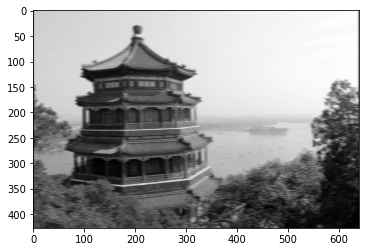

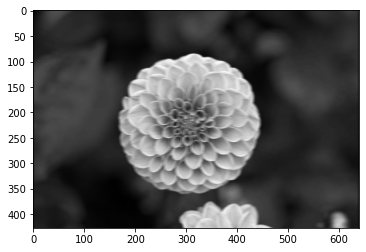

In [8]:
graph.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
graph.show()

graph.imshow(outputs[1, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
graph.show()

In [10]:
conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")

## Pooling layer

##### Max pool layer

In [12]:
# Max pool layer

max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [13]:
# Depth wise max pool

output = tf.nn.max_pool(images, 
                        ksize = (1, 1, 1, 3), 
                        strides = (1, 1, 1, 3), 
                        padding = 'VALID')

In [15]:
depth_pool = tf.keras.layers.Lambda(lambda X: tf.nn.max_pool(X, 
                                                             ksize = (1, 1, 1, 3), 
                                                             strides = (1, 1, 1, 3), 
                                                             padding = 'VALID'))

##### Global average pool

In [16]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

# CNN Architectures

In [17]:
from functools import partial

In [20]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, activation = 'relu', padding = 'same')

model = tf.keras.models.Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape = [28, 28, 1]), 
    tf.keras.layers.MaxPooling2D(pool_size = 2), 
    DefaultConv2D(filters = 128), 
    DefaultConv2D(filters = 128), 
    tf.keras.layers.MaxPooling2D(pool_size = 2), 
    DefaultConv2D(filters=256), 
    DefaultConv2D(filters=256), 
    tf.keras.layers.MaxPooling2D(pool_size=2), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=128, activation='relu'), 
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(units=64, activation = 'relu'), 
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(units=10, activation='softmax')])

# ResNet in Keras

In [153]:
from tensorflow import keras

In [154]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size = 3, strides = 1, padding = 'SAME', use_bias = False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation = 'relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides), 
            keras.layers.BatchNormalization(), 
            self.activation, 
            DefaultConv2D(filters), keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [DefaultConv2D(filters, kernel_size=1, strides=strides), 
                                keras.layers.BatchNormalization]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [157]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size = 7, strides = 2, input_shape = [224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides = 2, padding='SAME'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = 'softmax'))

TypeError: in user code:

    <ipython-input-154-8522ce30ddb5>:23 call  *
        skip_Z = layer(skip_Z)
    /home/arshad/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/normalization.py:191 __init__  **
        'argument \'axis\', but received: %r' % axis)

    TypeError: Expected an int or a list/tuple of ints for the argument 'axis', but received: <tf.Tensor 'residual_unit_4/conv2d_28/Conv2D:0' shape=(None, 28, 28, 128) dtype=float32>


# Using Pretrained models from Keras

In [158]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 14s 0us/step


In [159]:
images_resized = tf.image.resize(images, [224, 224])
inputs = keras.applications.resnet50.preprocess_input(images_resized * 225)

In [160]:
Y_proba = model.predict(inputs)

In [162]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
for class_id, name, y_proba in top_K[image_index]:
    print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 1us/step
Image #0
Image #1
 n03530642 - honeycomb    47.99%

 n13040303 - stinkhorn    32.99%

 n11939491 - daisy        4.14%



## Pretrained models for Transfer learning

In [163]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /home/arshad/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [164]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)

AssertionError: Unrecognized instruction format: NamedSplit('train')(tfds.percent[0:10])

In [166]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 10s 0us/step


# Classification and Localization

In [170]:
def long_repeat(line: str) -> int:
    """
        length the longest substring that consists of the same char
    """
    # your code here
    counts = []
    for letter in line:
        if letter in counts:
            if (counts == []) or (counts[-1][0] != letter):
                item_count = 1
                counts.append([letter, item_count])
            elif counts[-1][0] == letter:
                output[-1][1] += 1
    return output

In [171]:
long_repeat('ddvvrwwwrggg')

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_7')>

In [32]:
from datetime import date, timedelta


def checkio(from_date, to_date):
    """
        Count the days of rest
    """
    dates_between = [from_date + timedelta(days=x) for x in range((to_date-from_date).days + 1)]
    weekdays = [x for x in dates_between if x.weekday() is 5 or x.weekday() is 6]
    return len(weekdays)

#These "asserts" using only for self-checking and not necessary for auto-testing
if __name__ == '__main__':
    assert checkio(date(2013, 9, 18), date(2013, 9, 23)) == 2, "1st example"
    assert checkio(date(2013, 1, 1), date(2013, 2, 1)) == 8, "2nd example"
    assert checkio(date(2013, 2, 2), date(2013, 2, 3)) == 2, "3rd example"



In [16]:
from_date = date(2013, 1, 1)
to_date = date(2013, 2, 1)

[datetime.date(2013, 1, 5),
 datetime.date(2013, 1, 6),
 datetime.date(2013, 1, 12),
 datetime.date(2013, 1, 13),
 datetime.date(2013, 1, 19),
 datetime.date(2013, 1, 20),
 datetime.date(2013, 1, 26),
 datetime.date(2013, 1, 27)]

In [29]:
dates_between

[datetime.date(2013, 1, 1),
 datetime.date(2013, 1, 2),
 datetime.date(2013, 1, 3),
 datetime.date(2013, 1, 4),
 datetime.date(2013, 1, 5),
 datetime.date(2013, 1, 6),
 datetime.date(2013, 1, 7),
 datetime.date(2013, 1, 8),
 datetime.date(2013, 1, 9),
 datetime.date(2013, 1, 10),
 datetime.date(2013, 1, 11),
 datetime.date(2013, 1, 12),
 datetime.date(2013, 1, 13),
 datetime.date(2013, 1, 14),
 datetime.date(2013, 1, 15),
 datetime.date(2013, 1, 16),
 datetime.date(2013, 1, 17),
 datetime.date(2013, 1, 18),
 datetime.date(2013, 1, 19),
 datetime.date(2013, 1, 20),
 datetime.date(2013, 1, 21),
 datetime.date(2013, 1, 22),
 datetime.date(2013, 1, 23),
 datetime.date(2013, 1, 24),
 datetime.date(2013, 1, 25),
 datetime.date(2013, 1, 26),
 datetime.date(2013, 1, 27),
 datetime.date(2013, 1, 28),
 datetime.date(2013, 1, 29),
 datetime.date(2013, 1, 30),
 datetime.date(2013, 1, 31),
 datetime.date(2013, 2, 1)]

In [27]:
10 == (8 or 9)

False